In [ ]:
import numpy as np
import librosa
from typing import Optional, Tuple, List
from numpy import ndarray
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
DATA_DIR = "data"
LIST_OF_WORDS = ["bird", "eight", "four", "happy", "left", "marvin", "one", "seven", "three", "zero"]
OUTPUT_FILE = "processed_data.npz"
MAX_AUDIO_LENGTH = 17000
FRAME_SIZE = 512
OVERLAP_PERCENT = 50
HOP_LENGTH = int(FRAME_SIZE * (1 - OVERLAP_PERCENT / 100))
N_MELS = 64  

In [ ]:
def extract_log_mel_spectrogram_manual(file_path: str) -> Tuple[Optional[ndarray], Optional[ndarray], Optional[float]]:
    try:
        y, sr = librosa.load(file_path, sr=None) 

        if len(y) < MAX_AUDIO_LENGTH:
            pad_needed = MAX_AUDIO_LENGTH - len(y)
            pad_start = pad_needed // 2
            pad_end = pad_needed - pad_start
            y_proc = np.pad(y, (pad_start, pad_end), 'constant')
        elif len(y) > MAX_AUDIO_LENGTH:
            y_proc = y[:MAX_AUDIO_LENGTH]
        else:
            y_proc = y

        frames = librosa.util.frame(y, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH).T
        window = np.hamming(FRAME_SIZE)
        windowed_frames = frames * window
        stft_frames = np.fft.rfft(windowed_frames)
        power_spectrum = np.abs(stft_frames) ** 2
        mel_filterbank = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=N_MELS)
        mel_spectrum = np.dot(mel_filterbank, power_spectrum.T)
        eps = np.finfo(float).eps
        log_mel_spectrum = 10 * np.log10(mel_spectrum + eps)

        # --- Ensure consistent shape ---
        expected_frames = 1 + (MAX_AUDIO_LENGTH - FRAME_SIZE) // HOP_LENGTH
        current_frames = log_mel_spectrum.shape[1]

        if current_frames < expected_frames:
            pad_width = expected_frames - current_frames
            log_mel_spectrum = np.pad(log_mel_spectrum, ((0, 0), (0, pad_width)), mode='constant')
        elif current_frames > expected_frames:
            log_mel_spectrum = log_mel_spectrum[:, :expected_frames]

        return log_mel_spectrum.astype(np.float32)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def plot_log_mel_spec(mel_spec: ndarray, sr: int, hop_length: int):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        mel_spec,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title("Log-Mel Spectrogram (Manual Extraction)")
    plt.tight_layout()
    plt.show()

def process_all_data(data_dir: str, words: List[str]) -> Tuple[Optional[ndarray], Optional[ndarray], List[str]]:
    features: List[ndarray] = []
    labels: List[int] = []

    label_map = {word: i for i, word in enumerate(words)}
    print(f"Starting feature extraction")

    for _, word in enumerate(words):
        word_path = os.path.join(data_dir, word)

        # Find all .wav files in the directory
        file_list = glob.glob(os.path.join(word_path, '*.wav'))
        print(f"Processing '{word}': {len(file_list)} files found.")

        for file_path in file_list:
            # 1. Extract the feature matrix
            log_spec = extract_log_mel_spectrogram_manual(file_path)
            
            if log_spec is not None:
                features.append(log_spec)
                labels.append(label_map[word])
    
    if not features:
        print("No features were extracted. Check your data directory path.")
        return None, None, words

    # Convert the list of feature matrices and labels into NumPy arrays
    X = np.array(features, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)
    
    return X, y, words

Starting feature extraction
Processing 'bird': 100 files found.
Processing 'eight': 100 files found.
Processing 'four': 100 files found.
Processing 'happy': 100 files found.
Processing 'left': 100 files found.
Processing 'marvin': 100 files found.
Processing 'one': 100 files found.
Processing 'seven': 100 files found.
Processing 'three': 100 files found.
Processing 'zero': 100 files found.

--- Extraction Summary ---
Total samples processed: 1000
Feature matrix shape (N, Freq, Time): (1000, 64, 65)

Features successfully saved to processed_data.npz

--- Plotting Example Spectrogram for 'marvin' ---


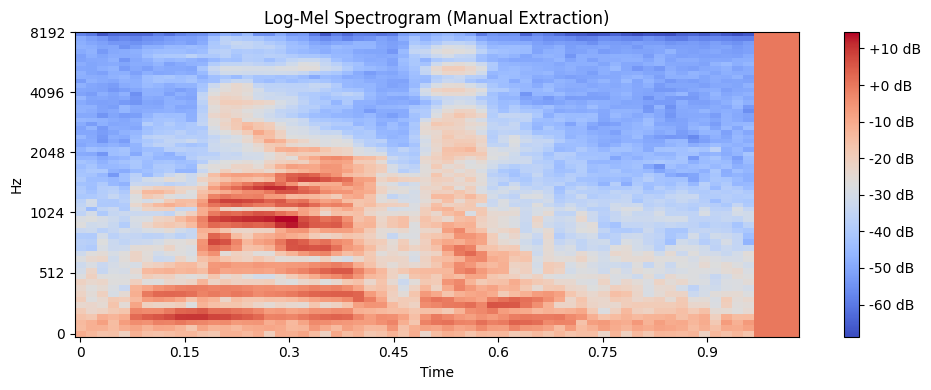

In [ ]:
if __name__ == '__main__':
    # --- 1. Full Data Processing (To generate features for training) ---
    X, y, label_names = process_all_data(DATA_DIR, LIST_OF_WORDS)
    
    if X is not None and y is not None:
        print(f"\n--- Extraction Summary ---")
        print(f"Total samples processed: {X.shape[0]}")
        print(f"Feature matrix shape (N, Freq, Time): {X.shape}")
        
        # Save the processed data for use in the model training script
        np.savez_compressed(
            OUTPUT_FILE, 
            X=X, 
            y=y, 
            label_names=np.array(label_names)
        )
        print(f"\nFeatures successfully saved to {OUTPUT_FILE}")

        # --- 2. Plotting an Example Spectrogram (Required for Phase 1) ---
        
        # Select one example file (e.g., the first 'marvin' file found)
        EXAMPLE_WORD = "marvin"
        example_path = glob.glob(os.path.join(DATA_DIR, EXAMPLE_WORD, '*.wav'))[0]
        
        clean_spec = extract_log_mel_spectrogram_manual(example_path)
        
        try:
            # Load with sr=None to get native SR (should be 16000)
            y_dummy, sr_plot = librosa.load(example_path, sr=None) 
        except Exception:
            sr_plot = 16000 # Fallback SR

        if clean_spec is not None:
            print(f"\n--- Plotting Example Spectrogram for '{EXAMPLE_WORD}' ---")
            # Use the defined plotting function
            plot_log_mel_spec(clean_spec, sr_plot, HOP_LENGTH)
        else:
            print(f"Failed to extract and plot clean spectrogram for {EXAMPLE_WORD}.")
        
    else:
        print("\nFeature extraction failed.")
